<a href="https://colab.research.google.com/github/okcza515/CPE342_Lab_CNN/blob/main/1092_Lab12_CNN_inClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab12 - Training Deep Convolutional Neural Network
- นายณัชพงศ์ ประมวลทรัพย์ 64070501092


## Lab Instruction

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use MNIST and Cat vs Dog dataset.

See http://yann.lecun.com/exdb/mnist <br>
See https://www.kaggle.com/c/dogs-vs-cats/data

In [ ]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import mnist

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# %load _utils
# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['sparse_categorical_accuracy'][-1])
    print('Last validation accuracy: %s'%history.history['val_sparse_categorical_accuracy'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):

    # Calculate result
    result = model.evaluate(features,labels,verbose=False)

    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)

    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))

    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28,channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')

    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### 1. Load MNIST dataset

In [ ]:
### Load dataset ###
(X_train,y_train), (X_test,y_test) = mnist.load_data()
####################

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train.shape

(60000, 28, 28)

### 2. Preprocess data

In [ ]:
def preprocess(data):
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
    data = data.astype('float32')/255.
    return data

X_train = preprocess(X_train)
X_test = preprocess(X_test)

In [ ]:
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

In [ ]:
BATCH_SIZE = 32

### 3. Build a convolutional neural network
Try to build a network that have a same or out perform our previous fully-connect model.

In [ ]:
cnn = models.Sequential()
cnn.add(layers.Conv2D(filters=32,
                      kernel_size=3,
                      padding='same',
                      activation = 'elu',
                      kernel_initializer='he_normal',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_1',
                     ))
cnn.add(layers.Conv2D(filters=32,
                      kernel_size=3,
                      padding='same',
                      activation = 'elu',
                      kernel_initializer='he_normal',
                      input_shape=(IMG_WIDTH,IMG_HEIGHT,CHANNEL,),
                      name = 'conv_2',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_1'))
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=3,
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'elu',
                      name = 'conv_3',
                     ))
cnn.add(layers.Conv2D(filters=64,
                      kernel_size=3,
                      padding='same',
                      kernel_initializer='he_normal',
                      activation = 'elu',
                      name = 'conv_4',
                     ))
cnn.add(layers.MaxPooling2D(2,2,name='max_pool_2'))
cnn.add(layers.Dropout(0.25,name='dropout_1'))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(256,activation='elu',
                     kernel_initializer='he_normal',
                     name='fully_connect_1'
                    ))
cnn.add(layers.Dropout(0.5,name='dropout_2'))
cnn.add(layers.Dense(10,activation='softmax',
                     kernel_initializer='he_normal',
                     name='output'
                    ))
cnn.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['sparse_categorical_accuracy'])
cnn.save('baseline_model.h5')
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 32)        9248      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 conv_3 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 conv_4 (Conv2D)             (None, 14, 14, 64)        36928     
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### 4. Trainig CNN Model

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0,stratify=y_train)

Epoch 1/20
844/844 [==============================] - 28s 13ms/step - loss: 0.1836 - sparse_categorical_accuracy: 0.9465 - val_loss: 0.0826 - val_sparse_categorical_accuracy: 0.9747
Epoch 2/20
844/844 [==============================] - 7s 9ms/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.0627 - val_sparse_categorical_accuracy: 0.9800
Epoch 3/20
844/844 [==============================] - 7s 8ms/step - loss: 0.0737 - sparse_categorical_accuracy: 0.9788 - val_loss: 0.0457 - val_sparse_categorical_accuracy: 0.9872
Epoch 4/20
844/844 [==============================] - 6s 8ms/step - loss: 0.0700 - sparse_categorical_accuracy: 0.9806 - val_loss: 0.0460 - val_sparse_categorical_accuracy: 0.9885
Epoch 5/20
844/844 [==============================] - 7s 8ms/step - loss: 0.0609 - sparse_categorical_accuracy: 0.9834 - val_loss: 0.0373 - val_sparse_categorical_accuracy: 0.9900
Epoch 6/20
844/844 [==============================] - 6s 8ms/step - loss: 0.0613 - sparse_categori

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Last train accuracy: 0.9898889064788818
Last validation accuracy: 0.9908333420753479


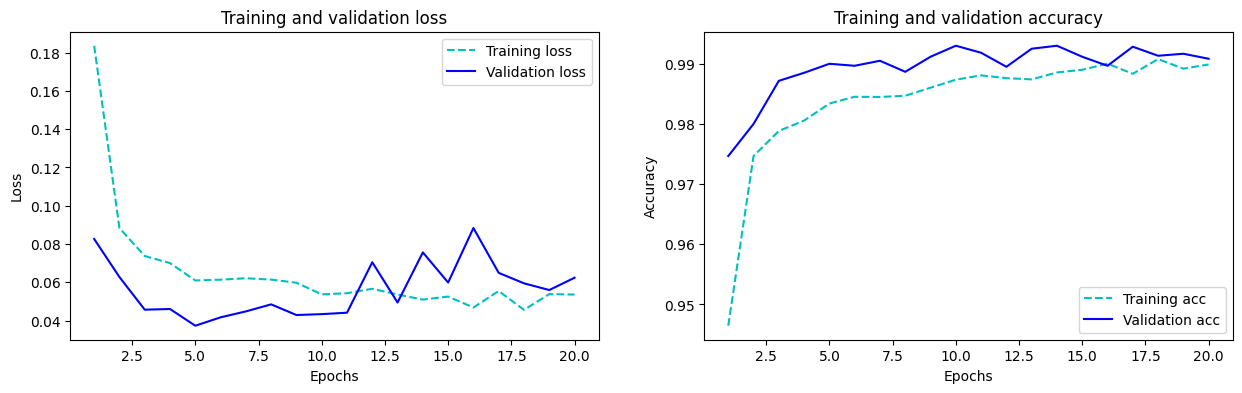

In [ ]:
history = cnn.fit(X_train,y_train,batch_size=64,epochs=20,validation_data=(X_val,y_val))
cnn.save('baseline_model_itr20.h5')
show_result(history)

```verbose=False``` will show you nothing (silent)

```verbose=TURE``` will show you an animated progress bar like this:
[==============================]


Last train accuracy: 0.9951481223106384
Last validation accuracy: 0.9943333268165588


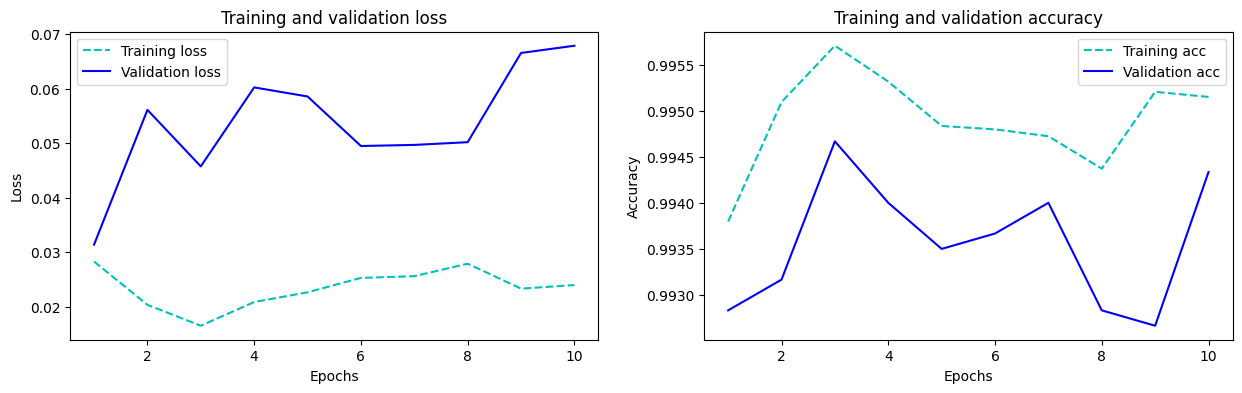

In [ ]:
history = cnn.fit(X_train,y_train,batch_size=128,epochs=10,validation_data=(X_val,y_val),verbose=False)
cnn.save('baseline_model_itr10_verboseFalse.h5')
show_result(history)

Last train accuracy: 0.9961481690406799
Last validation accuracy: 0.9950000047683716


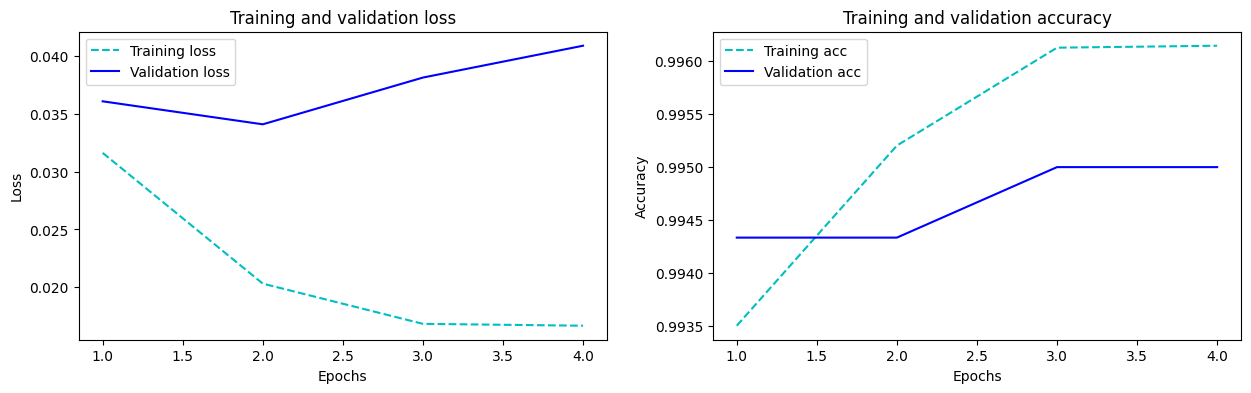

In [ ]:
cnn = models.load_model('baseline_model_itr20.h5')

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=2)
history = cnn.fit(X_train,y_train,batch_size=128,epochs=10,
                  validation_data=(X_val,y_val),
                  callbacks=[early_stop],
                  verbose=False)
cnn.save('baseline_model_itr10_earlystop.h5')
show_result(history)

### 5. Evaluate your model
#### 5.1 Show the confusion matrix and classification report
Using function ```evaluation_report(model,feature,label)``` define above to print the classification report

In [ ]:
pred_class = evaluation_report(cnn,X_test,y_test)

313/313 [==============================] - 1s 2ms/step
[[ 978    0    0    0    0    1    0    1    0    0]
 [   0 1131    0    0    0    0    3    0    1    0]
 [   0    0 1025    0    0    0    0    7    0    0]
 [   0    0    0 1006    0    2    0    1    1    0]
 [   0    0    0    0  981    0    0    0    0    1]
 [   0    1    0    6    0  883    1    0    0    1]
 [   2    1    1    0    1    3  950    0    0    0]
 [   0    2    0    0    0    0    0 1024    1    1]
 [   1    0    1    2    1    2    0    0  966    1]
 [   2    0    0    1    8    3    0    2    3  990]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      0.99      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99  

### 5.2 Show which image that your model incorrectly predict

Using function ```show_false_prediction(pred_class, actual_feature, actual_label)``` that is define above to show which image that your model predict wrong.

(66, 28, 28)


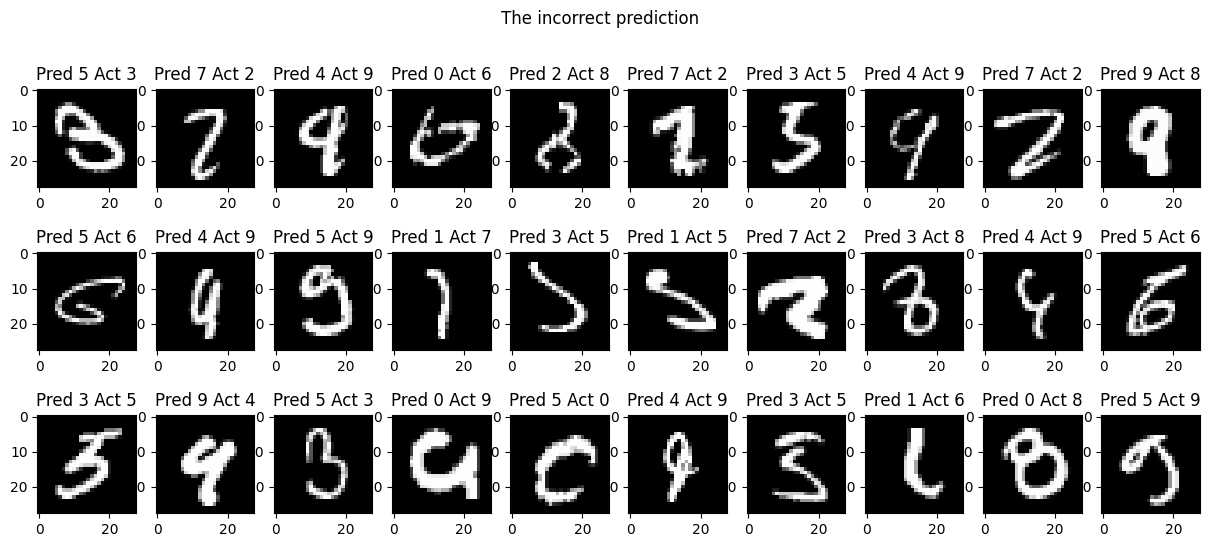

In [ ]:
show_false_prediction(pred_class, X_test, y_test)

**Discuss the results**

บางครั้งที่โมเดลทำนายผิดแม้ว่าภาพ input จะชัดเจน เช่น ภาพแถวที่ 3 รองจากภาพสุดท้าย เป็นภาพที่เห็นได้ชัดเจนว่าเป็นเลข 8 แต่โมเดลได้ทำนายออกมาเป็น 0
และก็มีบางครั้งโมเดลทำนายผิดเพราะภาพ input มีลักษณะไม่ชัดเจน ที่แม้แต่สายตาของมนุษย์ยังไม่สามารถบอกได้แน่ชัดว่าเป็นเลขอะไร เช่น แถวที่สอง ภาพที่ 4 ที่ได้ predict ว่าเป็น 1 แต่ label จริงคือ 7 จะเห็นว่าภาพนั้นแทบจะเป็นเส้นตรงเหมือนเลข 1 มากกว่าที่จะเป็นเส้นที่หักมุมเหมือนเลข 7  นั่นอาจเป็นสาเหตุที่ทำให้โมเดลยังทำนายภาพที่ชัดเจนบางภาพได้ผิด เพราะข้อมูลที่นำมาเทรนบางตัวไม่ชัดเจนนั่นเอง

### 5.3 Data Augmentation

Using the ```ImageDataGenerator``` module to generate more data. This technique is called data augmentation. It help generate more variation of the data which help prevent overfit and generalize better.

Lookup in the Keras document to see what method does it provide. https://keras.io/preprocessing/image

Becasue we want to build a data generator object, we have to re-load the data and specify rescale argument in ImageDataGenerator module.

In [ ]:
# Re-load the image data
(X_train,y_train), (X_test,y_test) = mnist.load_data()

# Because the ImageDataGenerator require tensor of 4 dimension
# Reshape data to 4 dimension (batch, width, height, channel)
def reshape_gray(data):
    data = data.reshape(data.shape[0],data.shape[1],data.shape[2],1)
    return data

X_train = reshape_gray(X_train)
X_test = reshape_gray(X_test)

# split to validation set and train set
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.1,random_state=0,stratify=y_train)

In [ ]:
# update global variable
IMG_WIDTH = X_train.shape[1]
IMG_HEIGHT = X_train.shape[2]
CHANNEL = X_train.shape[3]

BATCH_SIZE = 32

In [ ]:
# Define a generator for train set and test set

train_datagen = image.ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=False)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [ ]:
# Create an Iterator object.
train_generator = train_datagen.flow(X_train,y_train,
                                    batch_size = BATCH_SIZE,
                                    seed=0)

validate_generator = test_datagen.flow(X_val,y_val,
                                    batch_size = BATCH_SIZE,
                                    shuffle=False)

<ipython-input-19-396b1437952a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(train_generator,
/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Last train accuracy: 0.9335740804672241
Last validation accuracy: 0.9833333492279053


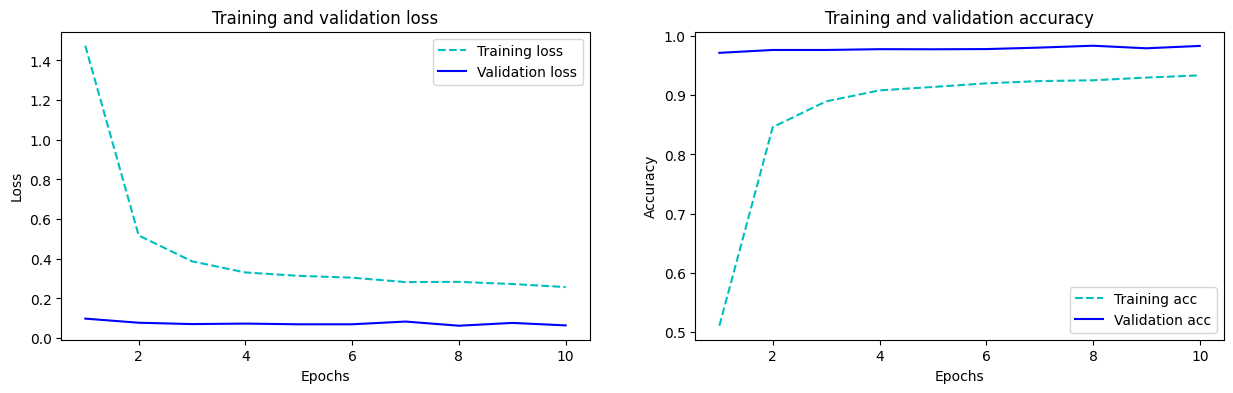

In [ ]:
# Using fit_generator to train your model. We don't need to specify the batch size since we already done that when we create Iterator
history = cnn.fit_generator(train_generator,
                              epochs=10,
                              verbose=0,
                              callbacks=None,
                              validation_data=validate_generator,
                              workers=8, use_multiprocessing=True)
cnn.save('baseline_model_itr10_data_aug.h5')
show_result(history)

<ipython-input-20-ac23c5d585be>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(train_generator,


Last train accuracy: 0.9430000185966492
Last validation accuracy: 0.9819999933242798


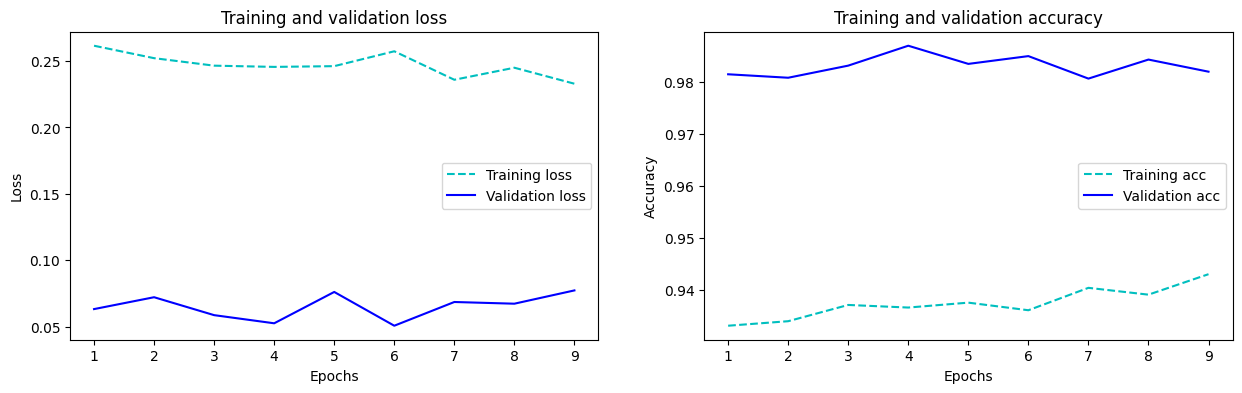

In [ ]:
# Add early stop
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Load previous model
cnn = models.load_model('baseline_model_itr10_data_aug.h5')


history = cnn.fit_generator(train_generator,
                              epochs=10,
                              verbose=0,
                              callbacks=[early_stop],
                              validation_data=validate_generator)

cnn.save('baseline_model_itr10_data_aug_earlystop.h5')
show_result(history)

<ipython-input-21-576efc70c2e1>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = cnn.fit_generator(train_generator,


Last train accuracy: 0.9483888745307922
Last validation accuracy: 0.9810000061988831


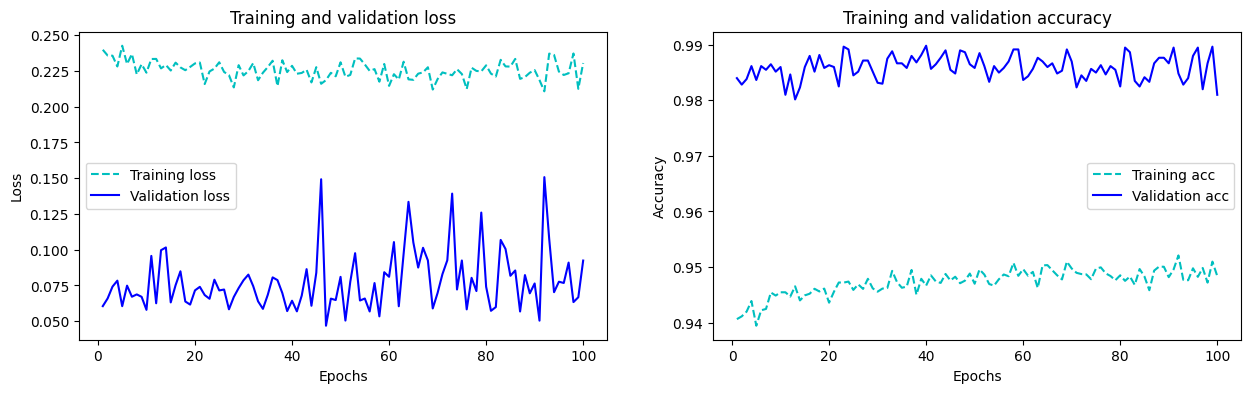

In [ ]:
# Let it run
history = cnn.fit_generator(train_generator,
                              epochs=100,
                              verbose=0,
                              validation_data=validate_generator)

cnn.save('baseline_model_itr100_data_aug.h5')
show_result(history)


**5.5 Compare the result**

Compare the result between a model with data augmentation and without data augmentation

จะเห็นว่าก่อนการทำ augmentation กราฟ loss และ accuracy ของการ train และ validation เส้นเกือบตรง ขณะที่หลังการทำ augmentation กราฟมีลักษณะเป็นเส้นสลับฟันปลา เนื่องจากว่าการทำ augmentation เป็นการ generate ข้อมูลเดิมให้มีความหลากหลายมากขึ้นทำให้โมเดลทำนายค่าได้แกว่งขึ้น เพื่อป้องกันการ overfit ของโมเดลกับข้อมูลเดิม accuracy กับ loss มันเลยขึ้้นๆ ลงๆ ในแต่ละ epochs

### 6. Visualize Layer Activation
**Note:** the function is defined above.

In [ ]:
# Create an activation model (the model with convolution layer only)

num_conv = 4# Number of convolutional layer in your model (if more than 4, just used 4)
layer_outputs = [layer.output for layer in cnn.layers[:num_conv]]
activation_model = models.Model(inputs=cnn.input, outputs=layer_outputs)
activation_model.summary()

In [ ]:
from keras.preprocessing import image

# load image to feed into network
img = image.load_img('/content/drive/MyDrive/Colab Notebooks/test_data_1.png',target_size=(28,28),grayscale=True)
img_tensor = image.img_to_array(img)

# Preprocess data
img_tensor = np.expand_dims(image.img_to_array(img),axis=0)/255.

# Feed into activation model to get an activation value
activation = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 210ms/step


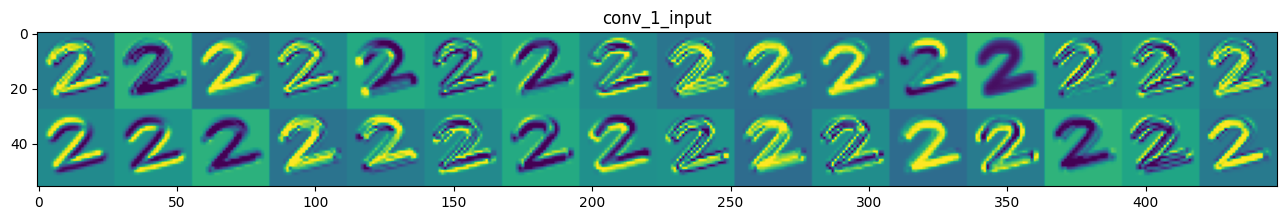

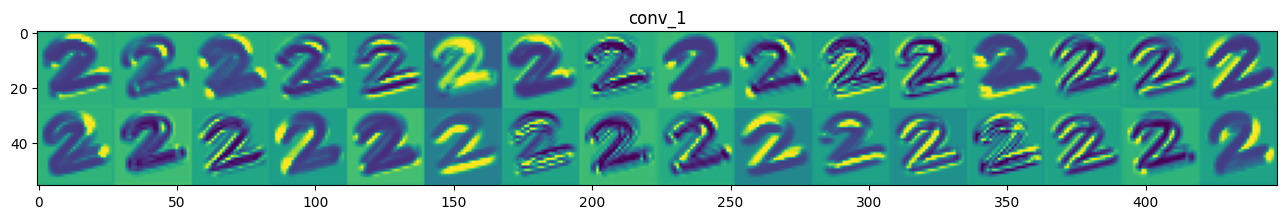

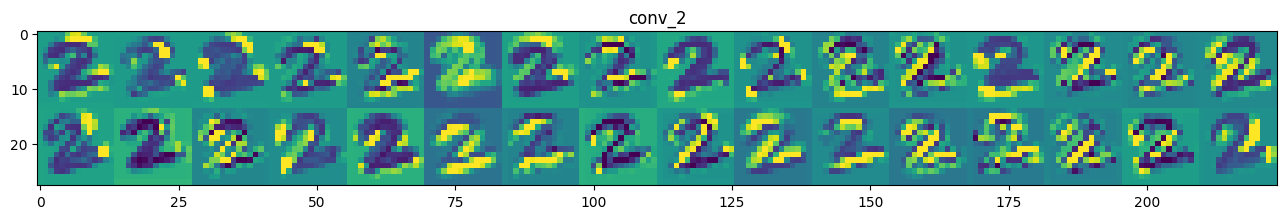

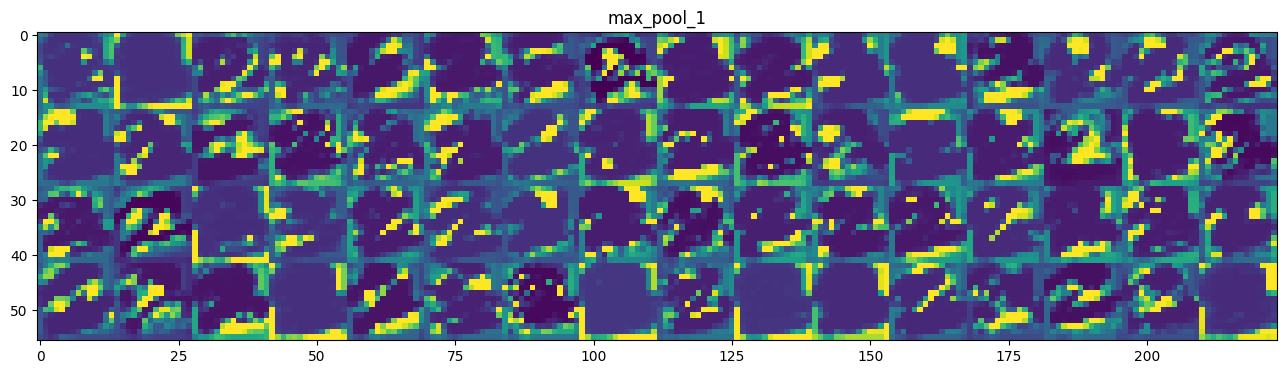

In [ ]:
### Feed your activation, model and number of layer you want to see
show_layer_activation(activation,activation_model,num_layer=4)

**What do you think the network can detect?**
- ใน conv_1 network น่าจะทำการ detect รูปร่างรวมๆของเลข เนื่องจากมีการตัดรายละเอียดส่วนอื่นให้เหลือเพียงรูปทรง
- ใน conv_2 network น่าจะทำการ detect เส้น ดูจากการลดความละเอียดของลูปให้เป็นการเรียงกันของ pixel

### 7. Transfer Learning
- What is transfer learning https://towardsdatascience.com/transfer-learning-946518f95666
- which transfer learning method to use https://medium.com/@14prakash/transfer-learning-using-keras-d804b2e04ef8

The following is a tutorial code to load and freeze some layer. Keras also come with a build-in pre-train network on imageNet dataset (See www.image-net.org)

Keras Pre-train Network https://keras.io/applications

#### 7.1.1 Use Build-in Pre-train Network
Keras come with a build-in pre-train network that let you download and use it in your problem. You can import only model structure or import neuron weight that had been train on imageNet.

In [ ]:
from keras.applications import vgg16

vgg = vgg16.VGG16(include_top=False,
                  weights='imagenet',
                  input_shape=(150,150,3))

In [ ]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

#### 7.1.2 Use Our Pre-train Network

When we are doing the deep learning/machine learning project, sometime, we may encounter a similar problem. After several project, we will have many existing model that we experiment and develop. We can used these model as a pre-train network to solve a new problem. This can save a hugh cost (time and money) and jump start our new project very quickly.

In [ ]:
prev_cnn = models.load_model('baseline_model_itr20.h5')
prev_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 32)        9248      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 conv_3 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 conv_4 (Conv2D)             (None, 14, 14, 64)        36928     
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

In [ ]:
# Use .pop() to remove the last layer
# In this case, we want to remove last two layer

prev_cnn.pop()
prev_cnn.pop()

In [ ]:
# See how our model change
prev_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 32)        9248      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 conv_3 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 conv_4 (Conv2D)             (None, 14, 14, 64)        36928     
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

For both method, if you want to change input size of your network, you have to create a model using functional API.
See https://keras.io/models/model

#### 7.2.1 Freezing layer - All

In [ ]:
# If we don't want to train these layer, we have to freeze these layer.
# Note that if we want a pre-train as a weight initializer, we don't have to freeze the layer.

prev_cnn.trainable = False

#### 7.2.2 Freezing layer - Specific layer

In [ ]:
# Freeze a specific layers
# Freeze first 3 layer
for i in range(3):
    prev_cnn.layers[i].trainable = False

#### 7.3 Connnect your model

In [ ]:
# Time to create a new model
new_cnn = models.Sequential()

# Add convolutional layer as a pre-train network
new_cnn.add(prev_cnn)

# Define fully-connect layer
new_cnn.add(layers.Dense(256,activation='elu'))
new_cnn.add(layers.Dropout(0.2))
new_cnn.add(layers.Dense(10,activation='softmax',name='output'))

# Show how your network looklike
new_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256)               868064    
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 output (Dense)              (None, 10)                2570      
                                                                 
Total params: 936426 (3.57 MB)
Trainable params: 68362 (267.04 KB)
Non-trainable params: 868064 (3.31 MB)
_________________________________________________________________


After this process, you can use your network as the way you like.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv_2 (Conv2D)             (None, 28, 28, 32)        9248      
                                                                 
 max_pool_1 (MaxPooling2D)   (None, 14, 14, 32)        0         
                                                                 
 conv_3 (Conv2D)             (None, 14, 14, 64)        18496     
                                                                 
 conv_4 (Conv2D)             (None, 14, 14, 64)        36928     
                                                                 
 max_pool_2 (MaxPooling2D)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/20
844/844 [==============================] - 7s 6ms/step - loss: 19.8396 - sparse_categorical_accuracy: 0.9686 - val_loss: 5.5356 - val_sparse_categorical_accuracy: 0.9847
Epoch 2/20
844/844 [==============================] - 5s 6ms/step - loss: 4.5486 - sparse_categorical_accuracy: 0.9815 - val_loss: 2.5476 - val_sparse_categorical_accuracy: 0.9872
Epoch 3/20
844/844 [==============================] - 5s 6ms/step - loss: 2.1992 - sparse_categorical_accuracy: 0.9821 - val_loss: 1.6548 - val_sparse_categorical_accuracy: 0.9867
Epoch 4/20
844/844 [==============================] - 4s 5ms/step - loss: 1.3336 - sparse_categorical_accuracy: 0.9814 - val_loss: 1.0304 - val_sparse_categorical_accuracy: 0.9855
Epoch 5/20
844/844 [==============================] - 4s 5ms/step - loss: 0.8762 - sparse_categorical_accuracy: 0.9767 - val_loss: 0.6737 - val_sparse_categorical_accuracy: 0.9825
Epoch 6/20
844/844 [==============================] - 5s 6ms/step - loss: 0.6009 - sparse_categoric

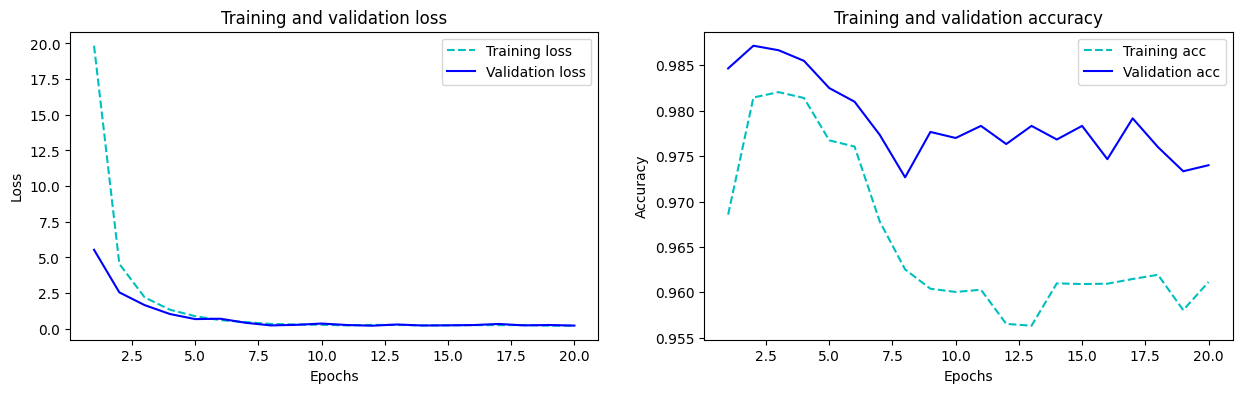

In [ ]:
new_cnn.compile(optimizer='adam',
           loss = 'sparse_categorical_crossentropy',
           metrics=['sparse_categorical_accuracy'])
cnn.save('baseline_model.h5')
cnn.summary()

history2 = new_cnn.fit(X_train,y_train,batch_size=64,epochs=20,validation_data=(X_val,y_val))
new_cnn.save('baseline_model_itr20.h5')
show_result(history2)

In [ ]:
pred_class = evaluation_report(new_cnn,X_test,y_test)

313/313 [==============================] - 1s 3ms/step
[[ 968    0    1    0    0    0    3    1    7    0]
 [   2 1114    0    2    0    0    0    0   17    0]
 [   0    0 1006    2    0    0    1    1   22    0]
 [   0    0    0  982    0    0    0    0   26    2]
 [   1    0    0    0  933    0    4    2   21   21]
 [   0    0    0    4    0  873    1    0   14    0]
 [   2    1    0    0    0    4  939    0   12    0]
 [   1    1    2    0    0    0    0  979   43    2]
 [   3    0    4    0    1    1    0    1  963    1]
 [   0    1    0    0    1    1    0    0   31  975]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.99      0.97      0.98      1032
           3       0.99      0.97      0.98      1010
           4       1.00      0.95      0.97       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98  

(268, 28, 28)


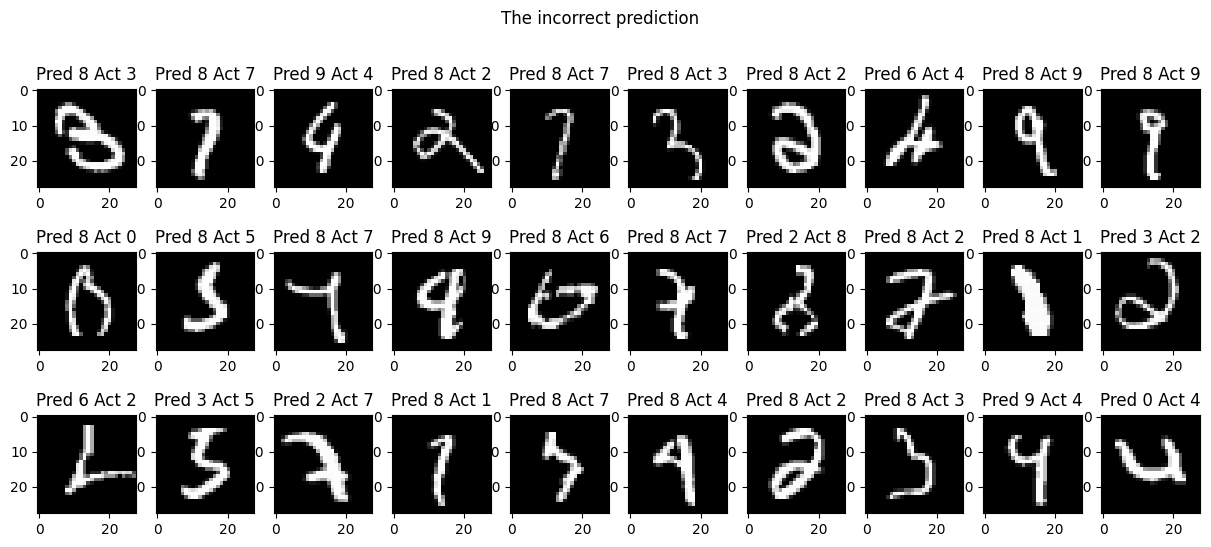

In [ ]:
show_false_prediction(pred_class, X_test, y_test)

 โมเดลทำนายออกมาได้แม่นยำด้วย accuracy 97% แต่ก็ยังมีการทำนายผิดกับตัวเลขที่เขีบนไม่ชัดเจนอยู่